In [1174]:
import os
import re
import numpy as np 
import time
import matplotlib.pyplot as plt 
import random
import networkx as nx
colores_rutas = ['green', 'orange', 'purple', 'brown', 'pink', 'blue', 'black', 'red', 'yellow', 'grey']

In [1175]:
with open ("INSTANCES/A/A-n45-k7.vrp") as archivo:
    nomb = ""
    dim = 0
    veh = 0
    cap = 0
    autos = []
    x_coord = []
    y_coord = []
    dema = {}  
    coordenadas = False  
    demandas = False  
    
    for linea in archivo:

        if linea.startswith("NAME"):
            nomb = (linea.strip().split(":")[1]).strip() + ".vrp"

        if linea.startswith("COMMENT"):
            resultado = re.search(r'of trucks:\s*(\d+)', linea, re.IGNORECASE)
            if resultado:
                veh = int(resultado.group(1))

        if linea.startswith("VEHIC"):
            veh = int(linea.strip().split(":")[1])
                
        if linea.startswith("DIMEN"):
            dim = int(linea.strip().split(":")[1])

        elif linea.startswith("CAPAC"):
            cap = int(linea.strip().split(":")[1])

        elif linea.startswith("NODE_COORD_SECTION"):
            coordenadas = True
            continue

        elif linea.startswith("DEMAND_SECTION"):
            coordenadas = False
            demandas = True
            continue

        elif linea.startswith("DEPOT_SECTION"):
            demandas = False

        elif coordenadas:
            coords = linea.split()
            if len(coords) >= 3:  
                x_coord.append(float(coords[1]))
                y_coord.append(float(coords[2]))

        elif demandas:
            demands = linea.split()
            if len(demands) >= 2:
                nodo, dem = int(demands[0]), int(demands[1])
                dema[nodo - 1] = dem  

for i in range(veh):
    autos.append(i+1)
        
cap_x_veh = {i: cap for i in range(1, veh + 1)}

In [1176]:
n = dim

clientes = [i for i in range(n)]
arcos = [(i,j) for i in range(n) for j in range(n) if i!=j]

vehiculos = veh
capacidad = cap
q = dema

x = x_coord
y = y_coord

In [1177]:
distancia = {(i,j): np.hypot(x[i] - x[j], y[i] - y[j]) for i,j in arcos}

In [1178]:
print(dema)

{0: 0, 1: 14, 2: 1, 3: 16, 4: 23, 5: 12, 6: 6, 7: 5, 8: 1, 9: 13, 10: 20, 11: 14, 12: 18, 13: 7, 14: 8, 15: 21, 16: 8, 17: 24, 18: 20, 19: 19, 20: 13, 21: 3, 22: 26, 23: 17, 24: 22, 25: 8, 26: 16, 27: 20, 28: 12, 29: 22, 30: 20, 31: 12, 32: 14, 33: 25, 34: 17, 35: 19, 36: 20, 37: 15, 38: 2, 39: 9, 40: 10, 41: 6, 42: 11, 43: 21, 44: 24}


In [1179]:
partida_tiempo = time.time()

# Implementacion de Local Seach
def Local_Search(clientes, distancia):
    min_cambio = 0
    for i in range(len(clientes)-2):
        for j in range(i+2, len(clientes)-1):
            costo_actual = distancia[(clientes[i], clientes[i+1])] + distancia[(clientes[j], clientes[j+1])]
            costo_nuevo = distancia[(clientes[i], clientes[j])] + distancia[(clientes[i+1], clientes[j+1])]
            cambio = costo_nuevo - costo_actual
            if cambio < min_cambio:
                min_cambio = cambio
                min_i = i
                min_j = j
    if min_cambio < 0:
        clientes[min_i + 1:min_j+1] = clientes[min_i+1:min_j+1][::-1]
    return clientes

# Definir tus datos de entrada (clientes, distancia)

# Ejecutar Local_Search 100 veces
for _ in range(100):
    clientes = Local_Search(clientes, distancia)

# Imprimir el resultado final después de 100 iteraciones
print(clientes)

[0, 12, 2, 39, 35, 34, 26, 21, 4, 6, 28, 3, 11, 43, 41, 27, 29, 31, 19, 36, 30, 33, 5, 22, 10, 37, 1, 42, 15, 25, 23, 17, 20, 16, 7, 40, 18, 13, 32, 38, 8, 9, 14, 24, 44]


In [1180]:
def dividir_lista(lista, demanda, limite):
    sub_listas = []
    sub_lista_actual = []
    suma_actual = 0

    for elemento in lista:
        demanda_elemento = demanda[elemento]

        if suma_actual + demanda_elemento <= limite:
            sub_lista_actual.append(elemento)
            suma_actual += demanda_elemento
        else:
            sub_listas.append(sub_lista_actual)
            sub_lista_actual = [elemento]
            suma_actual = demanda_elemento

    if sub_lista_actual:
        sub_listas.append(sub_lista_actual)

    # Eliminar el 0 de todas las listas y agregarlo al inicio
    for i in range(len(sub_listas)):
        sub_listas[i] = [x for x in sub_listas[i] if x != 0]
        sub_listas[i].insert(0, 0)

    return sub_listas

# Definir capacidad y llamar a la función
sub_listas_resultado = dividir_lista(clientes, q, capacidad)

print(sub_listas_resultado)

[[0, 12, 2, 39, 35, 34, 26, 21], [0, 4, 6, 28, 3, 11, 43, 41], [0, 27, 29, 31, 19, 36], [0, 30, 33, 5, 22], [0, 10, 37, 1, 42, 15, 25], [0, 23, 17, 20, 16, 7, 40, 18], [0, 13, 32, 38, 8, 9, 14, 24, 44]]


In [1181]:
def comparar_cantidad_listas_vehiculos(sub_listas, cantidad_vehiculos):
    cantidad_listas = len(sub_listas)
    
    if cantidad_listas == cantidad_vehiculos:
        print("La cantidad de listas es igual a la cantidad de vehículos.")
    elif cantidad_listas < cantidad_vehiculos:
        print("Hay menos listas que la cantidad de vehículos.")
    else:
        print("Hay más listas que la cantidad de vehículos.")

# Usar la función con las sub-listas generadas y la cantidad de vehículos
cantidad_vehiculos = vehiculos
comparar_cantidad_listas_vehiculos(sub_listas_resultado, cantidad_vehiculos)

La cantidad de listas es igual a la cantidad de vehículos.


In [1182]:
def calcular_distancia_ruta(ruta, distancia):
    distancia_total = 0
    for i in range(len(ruta) - 1):
        distancia_total += distancia[(ruta[i], ruta[i + 1])]
    return distancia_total

# Calcular distancias para cada ruta
distancias_rutas = [calcular_distancia_ruta(ruta, distancia) for ruta in sub_listas_resultado]

# Imprimir las distancias de cada ruta
for i, distancia_ruta in enumerate(distancias_rutas):
    print(f"Distancia de la Ruta {i + 1}: {distancia_ruta}")

# Calcular la sumatoria de las distancias de todas las rutas
distancia_total = sum(distancias_rutas)

final_tiempo = time.time()
total_tiempoNN = final_tiempo - partida_tiempo

print(f"\nSuma Total de Distancias: {distancia_total}")
print(f"\nEl tiempo total de ejecucion de NN: {total_tiempoNN}")

Distancia de la Ruta 1: 68.02329889123196
Distancia de la Ruta 2: 120.45490860951901
Distancia de la Ruta 3: 114.82151034841938
Distancia de la Ruta 4: 141.25399131631534
Distancia de la Ruta 5: 137.8570231013489
Distancia de la Ruta 6: 150.9294722662924
Distancia de la Ruta 7: 123.0655933856382

Suma Total de Distancias: 856.4057979187652

El tiempo total de ejecucion de NN: 0.07940959930419922


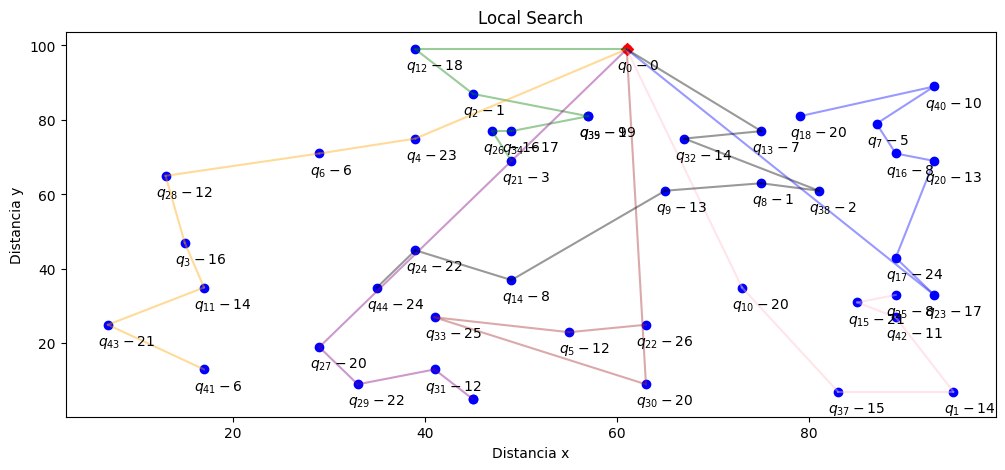

In [1183]:
# Grafico
plt.figure(figsize=(12, 5))

# Puntos
plt.scatter(x, y, color='blue')

# DC
plt.scatter(x[0], y[0], color='red', marker='D')

# Clientes y demanda
for i in clientes:
    plt.annotate('$q_{%d} - %d$' % (i, q[i]), (x[i] - 1, y[i] - 5.5))

# Rutas
for r in range(len(sub_listas_resultado)):
    color_ruta = colores_rutas[r % len(colores_rutas)]  # Ciclo de colores para las rutas
    for n in range(len(sub_listas_resultado[r]) - 1):
        i = sub_listas_resultado[r][n]
        j = sub_listas_resultado[r][n + 1]
        plt.plot([x[i], x[j]], [y[i], y[j]], alpha=0.4, color=color_ruta)

plt.xlabel("Distancia x")
plt.ylabel("Distancia y")
plt.title("Local Search")

plt.show()